In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler


In [3]:
# File paths for 2021-2024 datasets
file_paths = {
    2021: "../dataset/chennai-ground-water-levels-2021.csv",
    2022: "../dataset/chennai-ground-water-levels-2022.csv",
    2023: "../dataset/chennai-ground-water-levels-2023.csv",
    2024: "../dataset/chennai-ground-water-levels-2024.csv"
}

In [4]:
# Load all datasets into a single DataFrame
df_list = []
for year, path in file_paths.items():
    df = pd.read_csv(path)
    df["Year"] = year  # Add Year column
    df_list.append(df)

df_all_years = pd.concat(df_list)

In [5]:
# Fix month column names by stripping spaces
df_all_years.rename(columns=lambda x: x.strip(), inplace=True)

# Updated month list without spaces
months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", 
          "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

# Convert to numeric
df_all_years[months] = df_all_years[months].apply(pd.to_numeric, errors='coerce')

# Select a specific location for forecasting (e.g., Kathivakkam)
location = "Surappattu"
df_location = df_all_years[df_all_years["Location"] == location][["Year"] + months]

# Reshape into time series format
df_location = df_location.set_index("Year").stack().reset_index()
df_location.columns = ["Year", "Month", "Groundwater Level"]

# Strip extra spaces from Month column values
df_location["Month"] = df_location["Month"].str.strip()

# Convert to datetime
df_location["Date"] = pd.to_datetime(df_location["Year"].astype(str) + "-" + df_location["Month"], format="%Y-%b", errors="coerce")

# Drop any NaN values and set Date as index
df_location = df_location[["Date", "Groundwater Level"]].dropna()
df_location.set_index("Date", inplace=True)


In [6]:
# Normalize Data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df_location)

In [7]:
# Prepare Data for LSTM
sequence_length = 6  # Using last 6 months to predict the next month
X, y = [], []
for i in range(len(data_scaled) - sequence_length):
    X.append(data_scaled[i:i + sequence_length])
    y.append(data_scaled[i + sequence_length])

X, y = np.array(X), np.array(y)

In [8]:
# Split into training & testing sets
train_size = int(len(X) * 0.8)
X_train, X_test, y_train, y_test = X[:train_size], X[train_size:], y[:train_size], y[train_size:]


In [9]:
# Build LSTM Model
model = Sequential([
    LSTM(64, activation='relu', return_sequences=True, input_shape=(sequence_length, 1)),
    LSTM(64, activation='relu'),
    Dense(1)
])

d:\Capstone\El Nino\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [10]:
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=150, batch_size=8, verbose=1)


Epoch 1/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.3438
Epoch 2/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2938 
Epoch 3/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2763
Epoch 4/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2550 
Epoch 5/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2257 
Epoch 6/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2066 
Epoch 7/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1973 
Epoch 8/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1122
Epoch 9/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0891 
Epoch 10/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1072 
Epoch 11/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1121 
Epoch 12/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0973
Epoch 13/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1008
Epoch 14/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0916
Epoch 15/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0979 
Epoch 16/150
4/4 ━━

In [11]:
# Predict Next 12 Months
future_predictions = []
input_seq = data_scaled[-sequence_length:].reshape(1, sequence_length, 1)

for _ in range(12):  # Predict next 12 months
    next_value = model.predict(input_seq)[0]
    future_predictions.append(next_value)
    input_seq = np.append(input_seq[:, 1:, :], [[next_value]], axis=1)  # Slide window

# Convert back to original scale
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Generate future dates
future_dates = pd.date_range(start=df_location.index[-1] + pd.DateOffset(months=1), periods=12, freq="M")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


C:\Users\rumma\AppData\Local\Temp\ipykernel_13072\3243167485.py:14: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=df_location.index[-1] + pd.DateOffset(months=1), periods=12, freq="M")


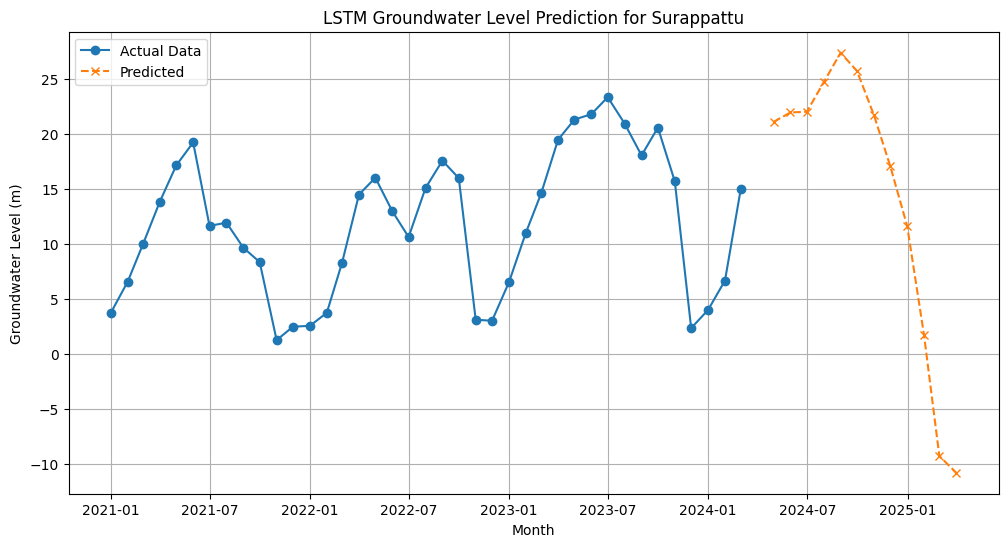

In [12]:
# Plot Results
plt.figure(figsize=(12, 6))
plt.plot(df_location.index, df_location["Groundwater Level"], marker='o', label="Actual Data")
plt.plot(future_dates, future_predictions, marker='x', linestyle="dashed", label="Predicted")
plt.xlabel("Month")
plt.ylabel("Groundwater Level (m)")
plt.title(f"LSTM Groundwater Level Prediction for {location}")
plt.legend()
plt.grid()
plt.show()